# merge table

&nbsp;

### 필요한 패키지 load

In [11]:
import fitz  
from IPython.display import Image, display
import base64
from dotenv import load_dotenv
from pydantic import BaseModel, ValidationError
from openai import AzureOpenAI
import os
import json

load_dotenv()

True

&nbsp;

### pdf load

In [48]:
doc = fitz.open("삼성생명약관.pdf")
page = doc.load_page(25)

&nbsp;

### markdown , base64 extract

In [50]:
tables_found = page.find_tables()


table_text = ''
for tbl in tables_found:
    
    # table markdown 추출 pymupdf 자체 기능
    md = tbl.to_markdown()
    
    extracted_rows = tbl.extract()
    for row in extracted_rows:
        cleaned_row = [str(cell) if cell is not None else "" for cell in row]
        table_text += "\t".join(cleaned_row) + "\n"

    # pymupdf 이미지 영역 -> base64 변환
    rect = fitz.Rect(*tbl.bbox)
    pix = page.get_pixmap(clip=rect, alpha=False)
    png_bytes = pix.tobytes("png")
    b64 = base64.b64encode(png_bytes).decode("utf-8")

doc.close()

In [51]:
print(table_text)

구분	자동차상해 특약 가입 시
보험가입금액 : 사망 1억 원, 부상
3천만 원, 휴유장애 1억		자기신체사고 가입 시
보험가입금액 :
사망 1억 원, 부상 3천만 원,
후유장애 1억	
내용	3개월간 치료비	500만 원	9급 한도인
200만 원 이내
실제 소요된
치료비 지급	200만 원
	3개월간
휴업손해비용	280만 원		
	위자료	25만 원		
보험금	총 805만 원 지급		총 200만 원 지급	
보험금의 차이	605만 원			



In [52]:
print(md)

|구분|자동차상해 특약 가입 시<br>보험가입금액 : 사망 1억 원, 부상<br>3천만 원, 휴유장애 1억|Col3|자기신체사고 가입 시<br>보험가입금액 :<br>사망 1억 원, 부상 3천만 원,<br>후유장애 1억|Col5|
|---|---|---|---|---|
|내용|3개월간 치료비|500만 원|9급 한도인<br>200만 원 이내<br>실제 소요된<br>치료비 지급|200만 원|
|내용|3개월간<br>휴업손해비용|280만 원|280만 원|280만 원|
|내용|위자료|25만 원|25만 원|25만 원|
|보험금|총 805만 원 지급|총 805만 원 지급|총 200만 원 지급|총 200만 원 지급|
|보험금의 차이|605만 원|605만 원|605만 원|605만 원|




base64 변환 이미지 :  iVBORw0KGgoAAAANSUhEUgAAAPgAAAB3CAIAAAChVRpRAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAu4klEQVR4nO2diVcU2bLu7z9311v3vPP6nu5zerDbdmoVR0CcEFEEmWQUZBJQUBBEJQERRQFBEUVQREUEZ5TRAZxaTw+a71cZss82C7DAAqrsihWLtcnKITL2tyO+yNyZ+V9Gz3DSzUGP0oTOgVm3waZpXUOzboNdPc9LaKoHOurmYO/rf//XucEXxoNnHqVZ3UOzboPnq89LrqsP6F6sPi+5rj6ge7GO56XsxjbbkgPX7xe037Gvdvay/m9JV1/RjZ69zdf1hYVX7xZeu+eiPXsuXDt854NJpfeejHkUpXsvdpR098+Yr3xA92JVXjp8e3D5pjDRBKN6/soAFsYWl68IjUCTyk/FHToWsbdYVl6wao00fl62mr+5568uDtrIOrEHK7blFq7aGikLw3IKaEQVHGE5DfbAT6JBMYnKBnYrR0k72cjR91+5zUL/8Jil60PWxaWoo+jrC/QDtu/IbWqfMV/5gO7FqnuppLtvUcC6nMY2YqoA/dDtgeLOR2B3R8lRBfQjdx///auvd5+5ZIxCcENiGphDw/cWKaCnVNWvDosyNKDL3kQXBwVrx+1nybr41F2jQCdU+0fE8tOSdSGkCBvQAyPjkypOGT6gO3ehT13xUun9pyB4x6FK2t/OXQDyZPkvazZAPwTorMPyjUnpLCzqeCAQLL7R88PCJURZArACemjG3u/n/2JYQJ/rtzKzrtmw8kb+pS4ayzZt1c2Apfzst+rQrQGAvnpbdFFHz4LVQcE7MxevdYwHG9B/Wrx8Y3KG4QO6cxcqVXwRzx7R1LaazhTxvmFFo73NHfo6dPPBm4+IPWoJvajUtk92YttcqU5AhZVax7r+yZXd7qXko7VglFjLuc9bvrq486Fh4XXtjp2GRTwAeuqJM5vTc/k37dS5+CN

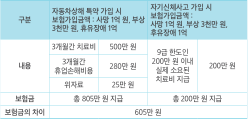

In [53]:
print("base64 변환 이미지 : ",b64)
display(Image(data=base64.b64decode(b64)))

&nbsp;

&nbsp;

### two-stage 구조화에서 병합된 table 까지 고려해서 구조화 한다면

In [69]:
class MergeTableToMarkdown(BaseModel):
    markdown: str



def get_merge_table_to_markdown(image_base64 : str, table_text: str) -> str:
    
    client = AzureOpenAI(
        azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
        api_key=os.getenv('AZURE_OPENAI_API_KEY'),
        api_version=os.getenv('AZURE_OPENAI_API_VERSION'),
    )
    
    # prompt는 GPT ^.^
    system_prompt = """
    당신은 보험 문서 표를 “정확한 격자(grid)”로 복원하는 전문가입니다.
    입력: 표 이미지 1장 (base64). 추가 텍스트나 OCR 제공 없음.
    목표: 이미지의 “시각적 구조(열/행/병합)”를 기준으로 격자를 재구성하고, 이미지에서 보이는 텍스트를 정확히 추출하여
    병합(rowspan/colspan)을 완전히 해제한 **완전한 Markdown 표**를 생성합니다.

    [핵심 원칙]
    1) 구조 우선: 열 수/열 경계/머리글/병합 위치는 전적으로 “이미지”를 기준으로 판정합니다.
    2) 내용 정확도: 숫자·단위·기호·띄어쓰기를 한 글자도 바꾸지 말고, 보이는 그대로 옮깁니다. 추측/요약/재표현 금지.
    3) 병합 해제: 원래 병합된 셀의 값은 해당 범위 내 **모든 셀에 반복 기입**하여 완전한 격자로 만듭니다.
    4) 열/행 순서 보존: 시각적 좌→우, 상→하 순서를 존중하며 순서를 임의 변경하지 않습니다.

    [격자 복원 절차(내부 사고만 하고, 출력은 표만)]
    1) 이미지에서 **열 경계**를 추정해 열 수를 확정합니다(좌→우, 열 너비·테두리·배경색·정렬 활용).
    2) **헤더 행**을 식별하고 열 이름을 설정합니다. 상단 병합 헤더는 반드시 열 헤더로 풉니다.
    3) 본문에서 **가로/세로 병합**을 식별하고, 병합 범위의 모든 셀을 동일 값으로 채웁니다.
    4) 좌측 첫 열이 섹션/구분 역할을 할 경우, 그 값은 해당 블록의 모든 하위 행에 **반복 기입**합니다.
    5) 모든 행이 동일한 열 개수와 올바른 정렬을 갖도록 보정합니다.

    [좌우 비교 표(매우 중요)]
    - 상단이나 좌우에 병합된 큰 범주의 셀(예: “자동차상해 특약”, “자기신체사고”)은
    **별도의 열 헤더로 분리하여 좌우 비교 구조를 유지**해야 합니다.
    - 가능한 기본 구조(예시):  
    | 구분 | [좌측 헤더] 내용 | [좌측 헤더] 보험금 | [우측 헤더] 내용 | [우측 헤더] 보험금 |
    - 빈 칸처럼 보이는 셀도 병합 해제를 위해 **반드시 값으로 채움**(해당 없음이면 “(해당 없음)” 또는 빈 문자열).

    [충돌/애매함 처리]
    - 문자 해독이 애매하면 가장 유력한 판독을 사용하되, 임의의 숫자 변경·추가 금지.
    - 합계/차이 등 합성 셀은 원래 위치의 열에만 기입합니다.

    [검증 체크리스트]
    - 모든 행이 동일한 열 개수인가?
    - 병합된 값이 누락 없이 반복 채워졌는가?
    - 숫자/단위/기호가 이미지와 정확히 일치하는가?
    - 좌우 비교 구조가 올바른 열로 분리되어 있는가?

    [출력 형식]
    - **오직 하나의 Markdown 표만 출력**합니다. 코드블록, 설명, 주석, 추가 문장은 금지.
    """
    try:
        response = client.beta.chat.completions.parse(
            model=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_base64}"}},
                    # {"type": "text", "text": "표에서 OCR/추출된 텍스트:\n" + table_text}, 
                ]},
            ],
            response_format=MergeTableToMarkdown,
            temperature=0,        
            max_tokens=2048,
            top_p=1,
        )
    
        parsed_data = response.choices[0].message.parsed
        
        return parsed_data.markdown

    except (ValidationError, json.JSONDecodeError) as e:
        return f"Error parsing model response: {e}", "", None



In [70]:
gpt_to_markdown = get_merge_table_to_markdown(b64,table_text)

In [71]:
print(gpt_to_markdown)

| 구분 | 내용 | 보험금 | 구분 | 내용 | 보험금 |
|------|------|--------|------|------|--------|
| 자동차상해 특약 가입 시 보험가입금액: 사망 1억 원, 부상 3천만 원, 후유장애 1억 | 3개월간 치료비 | 500만 원 | 자기신체사고 가입 시 보험가입금액: 사망 1억 원, 부상 3천만 원, 후유장애 1억 | 9급 한도인 200만 원 이내 실제 소요된 치료비 지급 | 200만 원 |
| 자동차상해 특약 가입 시 보험가입금액: 사망 1억 원, 부상 3천만 원, 후유장애 1억 | 3개월간 휴업손해비용 | 280만 원 | 자기신체사고 가입 시 보험가입금액: 사망 1억 원, 부상 3천만 원, 후유장애 1억 | (해당 없음) | (해당 없음) |
| 자동차상해 특약 가입 시 보험가입금액: 사망 1억 원, 부상 3천만 원, 후유장애 1억 | 위자료 | 25만 원 | 자기신체사고 가입 시 보험가입금액: 사망 1억 원, 부상 3천만 원, 후유장애 1억 | (해당 없음) | (해당 없음) |
| 자동차상해 특약 가입 시 보험가입금액: 사망 1억 원, 부상 3천만 원, 후유장애 1억 | 총 | 총 805만 원 지급 | 자기신체사고 가입 시 보험가입금액: 사망 1억 원, 부상 3천만 원, 후유장애 1억 | 총 | 총 200만 원 지급 |
| 보험금의 차이 | | 605만 원 | 보험금의 차이 | | 605만 원 |
